In [17]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data = {self.data})"
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else  Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _backward
        return out
        
    def __radd__(self, other):
        return self + other
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out
        
    def __rmul__(self, other):
        return self * other
        
    def __neg__(self):
        return self * -1
        
    def __sub__(self, other):
        return self + -other

    def __rsub__(self, other):
        return -self + other
        
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "can only accept int or float"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += out.grad * other * self.data**(other - 1)
        out._backward = _backward
        return out
        
    def __truediv__(self, other):
        return self * other**-1
        
    def __rtruediv__(self, other):
        return other * self**-1
        
    def exp(self):
        out = Value(math.exp(self.data), (self, ), 'exp')
        
        def _backward():
            self.grad += out.grad * math.exp(self.data)
        out._backward = _backward
        return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += out.grad * (1 - t**2)
        out._backward = _backward
        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self, ), 'relu')
        def _backward():
            self.grad += out.grad * (self.data > 0)
        out._backward = _backward
        return out
        
    def backward(self):
        self.grad = 1.0
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        for node in reversed(topo):
            node._backward()

In [26]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    nodes, edges = trace(root)
    dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'})
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for (n1, n2) in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [28]:
import torch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True

b = torch.Tensor([2.0]).double() ; b.requires_grad = True

act = x1*w1 + x2*w2 + b

out = torch.tanh(act)
out.backward()

print(f'out.data = {out.data.item()}')
print('_____')
print(f'x1.grad = {x1.grad.item()}')
print(f'x2.grad = {x2.grad.item()}')
print(f'w1.grad = {w1.grad.item()}')
print(f'w2.grad = {w2.grad.item()}')
print(f'b.grad = {b.grad.item()}')

out.data = -0.999329299739067
_____
x1.grad = -0.004022852049077749
x2.grad = 0.0013409506830259165
w1.grad = 0.002681901366051833
w2.grad = 0.0
b.grad = 0.0013409506830259165


In [66]:
class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0
            
    def parameters(self):
        return []

class Neuron(Module):
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((xi*wi for xi, wi in zip(x, self.w)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
            
    def __repr__(self):
        return f'Neuron({nin})'

class Layer(Module):
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
    def __repr__(self):
        return f'Layer({len(self.neurons)})'

class MLP(Module):
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
            
    def __repr__(self):
        return f'MLP({len(self.layers)})'

In [67]:
model = MLP(2, [16, 16, 1])
print(model)
print(f'Number of parameters = {len(model.parameters())}')

MLP(3)
Number of parameters = 337


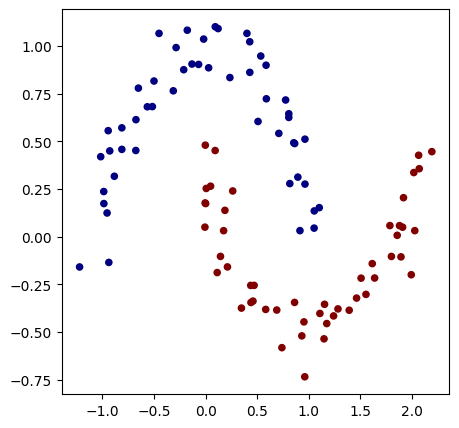

In [68]:
from sklearn.datasets import make_moons, make_blobs

X, y = make_moons(n_samples = 100, noise = 0.1)
y = 2*y - 1

plt.figure(figsize = (5, 5))
plt.scatter(X[:, 0], X[:, 1], c = y, s = 20, cmap = 'jet')

In [69]:
def loss(batch_size = None):
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    inputs = [list(map(Value, xrow)) for xrow in Xb]
    scores = list(map(model, inputs))

    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * 1.0 / len(losses)

    alpha = 1e-4
    reg_loss = alpha * sum([p*p for p in model.parameters()])

    total_loss = data_loss + reg_loss

    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]

    return total_loss, sum(accuracy) / len(accuracy)

In [71]:
for k in range(100):
    total_loss, acc = loss()
    
    model.zero_grad()
    total_loss.backward()

    learning_rate = 1 - 0.9*k/100
    
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    print(f'step = {k + 1}, loss = {total_loss.data}, accuracy = {acc * 100}%')

step = 1, loss = 0.3536702599363059, accuracy = 0.84%
step = 2, loss = 0.3321913578881611, accuracy = 0.84%
step = 3, loss = 0.30681874566865486, accuracy = 0.86%
step = 4, loss = 0.284259115862802, accuracy = 0.88%
step = 5, loss = 0.2693074346507215, accuracy = 0.89%
step = 6, loss = 0.2595610403697829, accuracy = 0.9%
step = 7, loss = 0.25200721242839225, accuracy = 0.89%
step = 8, loss = 0.2438780004549511, accuracy = 0.9%
step = 9, loss = 0.23811669452630754, accuracy = 0.89%
step = 10, loss = 0.23097151040909958, accuracy = 0.9%
step = 11, loss = 0.22560101691093423, accuracy = 0.91%
step = 12, loss = 0.2198928808199597, accuracy = 0.91%
step = 13, loss = 0.214730119723083, accuracy = 0.91%
step = 14, loss = 0.20971688197693988, accuracy = 0.91%
step = 15, loss = 0.2046517670044405, accuracy = 0.91%
step = 16, loss = 0.19918772438800264, accuracy = 0.91%
step = 17, loss = 0.1930852746748183, accuracy = 0.92%
step = 18, loss = 0.18651013982421244, accuracy = 0.92%
step = 19, loss 

(-1.7335964483301152, 2.016403551669885)

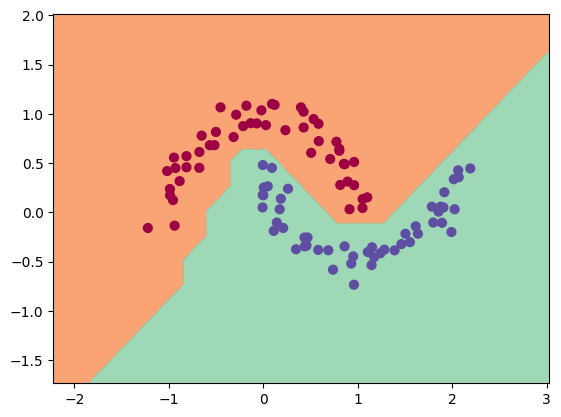

In [75]:
h = 0.25

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1


xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Xmesh = np.c_[xx.ravel(), yy.ravel()]

inputs = [list(map(Value, xrow)) for xrow in Xmesh]

scores = list(map(model, inputs))

Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())